In [1]:
import os
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 7-1 (Query Translation - Decomposition (Recursive))"

# Query translation

![](images/query-translation-01.png)

![](images/query-translation-02.png)

# Part 7-1: Decomposition (Recursive)

![](images/07-01-decomposition-recursive.png)

## Configure components

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BKNGfeKgTo7Gx5r6pOBqSywyW2ddS', 'finish_reason': 'stop', 'logprobs': None}, id='run-3738a343-c9ce-4035-8f94-6ba314ad2f3d-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

1

In [9]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

## Split documents

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
len(splits)

66

## Store documents

In [12]:
from langchain_core.vectorstores import InMemoryVectorStore

In [13]:
vectorstore = InMemoryVectorStore(embeddings)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

(66, 66)

In [14]:
retriever = vectorstore.as_retriever()

## RAG

In [15]:
import operator
from typing import Annotated, Literal, TypedDict

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field

In [16]:
decomposition_prompt_template = """You are a helpful assistant that generates multiple sub-questions related to an input question.
The goal is to break down the input into a set of sub-problems / sub-questions that can be answered sequentially.
Generate multiple search queries related to: {question}"""
print(decomposition_prompt_template)

You are a helpful assistant that generates multiple sub-questions related to an input question.
The goal is to break down the input into a set of sub-problems / sub-questions that can be answered sequentially.
Generate multiple search queries related to: {question}


In [17]:
recursive_prompt_template = """Here is the question you need to answer:
<question>
{question}
</question>

Here are any available background question + answer pairs:
<question_answer_pairs>
{qa_pairs}
</question_answer_pairs>

Here is additional context relevant to the question: 
<context>
{context}
</context>

Use the above context and any background question + answer pairs to answer the question:
<question>
{question}
</question>
"""
print(recursive_prompt_template)

Here is the question you need to answer:
<question>
{question}
</question>

Here are any available background question + answer pairs:
<question_answer_pairs>
{qa_pairs}
</question_answer_pairs>

Here is additional context relevant to the question: 
<context>
{context}
</context>

Use the above context and any background question + answer pairs to answer the question:
<question>
{question}
</question>



In [18]:
def format_qa_pair(question, answer):
    return f"Question: {question}  \nAnswer:\n{answer}\n\n"

In [19]:
query = "What are the main components of an LLM-powered autonomous agent system?"

In [20]:
class State(TypedDict):
    question: str
    all_questions: list[str]
    current_question_idx: int
    qa_pairs: list[str]
    context: list[Document]
    answer: str

In [21]:
def generate_sub_questions(state: State, config: RunnableConfig) -> list[str]:
    max_generated_sub_questions_count = config['configurable'].get("max_generated_sub_questions_count", 3)
    query = state['question']
    
    class SubQuestionsGenerator(BaseModel):
        sub_questions: list[str] = Field(
            ..., 
            description="List of generated sub-problems / sub-questions",
            max_items=max_generated_sub_questions_count
        )
    
    structured_llm = llm.with_structured_output(SubQuestionsGenerator, method="function_calling")
    decomposition_prompt = decomposition_prompt_template.format(
        question=query
    )
    response = structured_llm.invoke([
        HumanMessage(content=decomposition_prompt)
    ])
    questions = response.sub_questions + [query]
    
    return {"all_questions": questions, "current_question_idx": 0}


def retrieve_docs(state: State):
    question = state["all_questions"][state["current_question_idx"]]
    retrieved_docs = vectorstore.similarity_search(question)
    return {"context": retrieved_docs}


def generate_answer(state: State):
    question = state["all_questions"][state["current_question_idx"]]
    recursive_prompt = recursive_prompt_template.format(
        question=question,
        qa_pairs=state.get("qa_pairs", ""),
        context=state["context"]
    )
    answer = llm.invoke([
        HumanMessage(content=recursive_prompt)
    ])
    qa_pair = format_qa_pair(question, answer.content)
    qa_pairs = state.get("qa_pairs", "") + qa_pair

    if state["current_question_idx"] == len(state['all_questions']) - 1:
        return {"answer": answer.content}
    else:
        return {"qa_pairs": qa_pairs, "current_question_idx": state["current_question_idx"] + 1}


def check_answer_status(state: State) -> Literal["Next sub-question", "Final answer"]:
    if state.get("answer"):
        return "Final answer"
    else:
        return "Next sub-question"

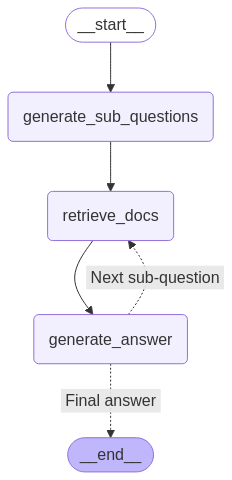

In [22]:
graph_builder = StateGraph(State)

graph_builder.add_node("generate_sub_questions", generate_sub_questions)
graph_builder.add_node("retrieve_docs", retrieve_docs)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "generate_sub_questions")
graph_builder.add_edge("generate_sub_questions", "retrieve_docs")
graph_builder.add_edge("retrieve_docs", "generate_answer")
graph_builder.add_conditional_edges(
    "generate_answer", 
    check_answer_status, 
    {
        "Next sub-question": "retrieve_docs",
        "Final answer": END
    }
)

graph = graph_builder.compile()
graph

In [23]:
config = {
    "configurable": {
        "max_generated_sub_questions_count": 3
    }
}

for stream_mode, event in graph.stream(
    {"question": query}, 
    stream_mode=["messages", "updates"],
    config=config
):
    match stream_mode:
        case "messages":
            message, metadata = event
            print(message.content, end="", flush=True)
        case "updates":
            rprint(event)

display(Markdown(event['generate_answer']['answer']))

{
    'generate_sub_questions': {
        'all_questions': [
            'What are the core functionalities of an LLM-powered autonomous agent?',
            'What types of data inputs do LLM-powered autonomous agents utilize?',
            'What roles do machine learning and natural language processing play in LLM-powered autonomous 
agents?',
            'What are the main components of an LLM-powered autonomous agent system?'
        ],
        'current_question_idx': 0
    }
}

{
    'retrieve_docs': {
        'context': [
            Document(
                id='e1348f72-0909-4172-810d-c8426af405b3',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 
31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a 
cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring 
examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it 
can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent 
system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and 
decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of 
complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, 
learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'
            ),
            Document(
                id='8dc59e3e-032a-4b3d-bd9c-72f5b3da7115',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: 
Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan 
ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for 
enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more 
test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into 
multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'
            ),
            Document(
                id='f6b06016-6811-438c-8247-30969b60fafe',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Reliability of natural language interface: Current agent system relies on natural 
language as an interface between LLMs and external components such as memory and tools. However, the reliability of
model outputs is questionable, as LLMs may make formatting errors and occasionally exhibit rebellious behavior 
(e.g. refuse to follow an instruction). Consequently, much of the agent demo code focuses on parsing model 
output.\n\n\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. 
https://lilianweng.github.io/posts/2023-06-23-agent/.'
            ),
            Document(
                id='1a067f40-2114-4e46-9a49-a893bccf6d9f',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='}\n]\nChallenges#\nAfter going through key ideas and demos of building LLM-centered 
agents, I start to see a couple common limitations:'
            )
        ]
    }
}

The core functionalities of an LLM-powered autonomous agent include:

1. **Planning**: The agent can break down complex tasks into smaller, manageable subgoals. This involves task decomposition, where the agent utilizes techniques like chain of thought (CoT) to think step-by-step and transform large tasks into simpler ones.

2. **Reflection and Refinement**: The agent has the ability to engage in self-criticism and self-reflection regarding its past actions. This functionality allows the agent to learn from mistakes and refine its approaches for better outcomes in future tasks.

3. **Use of Memory**: While not detailed in the provided context, memory plays a crucial role in allowing the agent to retain and utilize information from previous interactions or tasks, which aids in improving performance and decision-making.

4. **Natural Language Interface**: The agent relies on natural language as the primary interface for interacting with external components, including tools and memory sys

{
    'generate_answer': {
        'qa_pairs': 'Question: What are the core functionalities of an LLM-powered autonomous agent?  
\nAnswer:\nThe core functionalities of an LLM-powered autonomous agent include:\n\n1. **Planning**: The agent can 
break down complex tasks into smaller, manageable subgoals. This involves task decomposition, where the agent 
utilizes techniques like chain of thought (CoT) to think step-by-step and transform large tasks into simpler 
ones.\n\n2. **Reflection and Refinement**: The agent has the ability to engage in self-criticism and 
self-reflection regarding its past actions. This functionality allows the agent to learn from mistakes and refine 
its approaches for better outcomes in future tasks.\n\n3. **Use of Memory**: While not detailed in the provided 
context, memory plays a crucial role in allowing the agent to retain and utilize information from previous 
interactions or tasks, which aids in improving performance and decision-making.\n\n4. **Natural Language 
Interface**: The agent relies on natural language as the primary interface for interacting with external 
components, including tools and memory systems. This makes the interaction more accessible, though it also 
introduces challenges regarding reliability and output parsing.\n\nThese functionalities enable LLM-powered 
autonomous agents to effectively solve complex problems and manage tasks efficiently.\n\n',
        'current_question_idx': 1
    }
}

{
    'retrieve_docs': {
        'context': [
            Document(
                id='e1348f72-0909-4172-810d-c8426af405b3',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 
31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a 
cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring 
examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it 
can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent 
system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and 
decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of 
complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, 
learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'
            ),
            Document(
                id='f6b06016-6811-438c-8247-30969b60fafe',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Reliability of natural language interface: Current agent system relies on natural 
language as an interface between LLMs and external components such as memory and tools. However, the reliability of
model outputs is questionable, as LLMs may make formatting errors and occasionally exhibit rebellious behavior 
(e.g. refuse to follow an instruction). Consequently, much of the agent demo code focuses on parsing model 
output.\n\n\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. 
https://lilianweng.github.io/posts/2023-06-23-agent/.'
            ),
            Document(
                id='8dc59e3e-032a-4b3d-bd9c-72f5b3da7115',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: 
Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan 
ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for 
enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more 
test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into 
multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'
            ),
            Document(
                id='f1753d3a-f19b-4be6-a487-d07baa23f0ce',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 13. The generative agent architecture. (Image source: Park et al. 2023)\nThis 
fun simulation results in emergent social behavior, such as information diffusion, relationship memory (e.g. two 
agents continuing the conversation topic) and coordination of social events (e.g. host a party and invite many 
others).\nProof-of-Concept Examples#\nAutoGPT has drawn a lot of attention into the possibility of setting up 
autonomous agents with LLM as the main controller. It has quite a lot of reliability issues given the natural 
language interface, but nevertheless a cool proof-of-concept demo. A lot of code in AutoGPT is about format 
parsing.\nHere is the system message used by AutoGPT, where {{...}} are user inputs:\nYou are {{ai-name}}, 
{{user-provided AI bot description}}.\nYour decisions must always be made independently without seeking user 
assistance. Play to your strengths as an LL

LLM-powered autonomous agents utilize several types of data inputs, primarily centered around natural language. The key types of data inputs include:

1. **User Queries and Instructions**: Agents take direct input from users in the form of natural language queries or commands. This allows users to specify tasks or provide context for the agent's actions.

2. **Memory and Contextual Information**: Agents may leverage memory to retain data from previous interactions or tasks. This information helps improve decision-making and maintain context in ongoing conversations or tasks.

3. **External Data and Tools**: Depending on the design, agents can integrate data from external systems or tools to enhance their functionality. This might include accessing APIs, databases, or sensors.

4. **Formatted Outputs for Parsing**: The agents may also rely on structured outputs from external components, which are parsed to facilitate clear communication and action based on the model's understanding.

Ov

{
    'generate_answer': {
        'qa_pairs': "Question: What are the core functionalities of an LLM-powered autonomous agent?  
\nAnswer:\nThe core functionalities of an LLM-powered autonomous agent include:\n\n1. **Planning**: The agent can 
break down complex tasks into smaller, manageable subgoals. This involves task decomposition, where the agent 
utilizes techniques like chain of thought (CoT) to think step-by-step and transform large tasks into simpler 
ones.\n\n2. **Reflection and Refinement**: The agent has the ability to engage in self-criticism and 
self-reflection regarding its past actions. This functionality allows the agent to learn from mistakes and refine 
its approaches for better outcomes in future tasks.\n\n3. **Use of Memory**: While not detailed in the provided 
context, memory plays a crucial role in allowing the agent to retain and utilize information from previous 
interactions or tasks, which aids in improving performance and decision-making.\n\n4. **Natural Language 
Interface**: The agent relies on natural language as the primary interface for interacting with external 
components, including tools and memory systems. This makes the interaction more accessible, though it also 
introduces challenges regarding reliability and output parsing.\n\nThese functionalities enable LLM-powered 
autonomous agents to effectively solve complex problems and manage tasks efficiently.\n\nQuestion: What types of 
data inputs do LLM-powered autonomous agents utilize?  \nAnswer:\nLLM-powered autonomous agents utilize several 
types of data inputs, primarily centered around natural language. The key types of data inputs include:\n\n1. 
**User Queries and Instructions**: Agents take direct input from users in the form of natural language queries or 
commands. This allows users to specify tasks or provide context for the agent's actions.\n\n2. **Memory and 
Contextual Information**: Agents may leverage memory to retain data from previous interactions or tasks. This 
information helps improve decision-making and maintain context in ongoing conversations or tasks.\n\n3. **External 
Data and Tools**: Depending on the design, agents can integrate data from external systems or tools to enhance 
their functionality. This might include accessing APIs, databases, or sensors.\n\n4. **Formatted Outputs for 
Parsing**: The agents may also rely on structured outputs from external components, which are parsed to facilitate 
clear communication and action based on the model's understanding.\n\nOverall, the agents primarily rely on natural
language inputs, but they can also incorporate a variety of structured and contextual data to enhance their 
capabilities.\n\n",
        'current_question_idx': 2
    }
}

{
    'retrieve_docs': {
        'context': [
            Document(
                id='e1348f72-0909-4172-810d-c8426af405b3',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 
31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a 
cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring 
examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it 
can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent 
system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and 
decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of 
complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, 
learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'
            ),
            Document(
                id='f6b06016-6811-438c-8247-30969b60fafe',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Reliability of natural language interface: Current agent system relies on natural 
language as an interface between LLMs and external components such as memory and tools. However, the reliability of
model outputs is questionable, as LLMs may make formatting errors and occasionally exhibit rebellious behavior 
(e.g. refuse to follow an instruction). Consequently, much of the agent demo code focuses on parsing model 
output.\n\n\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. 
https://lilianweng.github.io/posts/2023-06-23-agent/.'
            ),
            Document(
                id='4970d8b4-3ff7-41b8-a3b0-a2e2a2c61615',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Or\n@article{weng2023agent,\n  title   = "LLM-powered Autonomous Agents",\n  author  
= "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2023",\n  month   = "Jun",\n  url     = 
"https://lilianweng.github.io/posts/2023-06-23-agent/"\n}\nReferences#\n[1] Wei et al. “Chain of thought prompting 
elicits reasoning in large language models.” NeurIPS 2022\n[2] Yao et al. “Tree of Thoughts: Dliberate Problem 
Solving with Large Language Models.” arXiv preprint arXiv:2305.10601 (2023).\n[3] Liu et al. “Chain of Hindsight 
Aligns Language Models with Feedback\n“ arXiv preprint arXiv:2302.02676 (2023).\n[4] Liu et al. “LLM+P: Empowering 
Large Language Models with Optimal Planning Proficiency” arXiv preprint arXiv:2304.11477 (2023).\n[5] Yao et al. 
“ReAct: Synergizing reasoning and acting in language models.” ICLR 2023.\n[6] Google Blog. “Announcing ScaNN: 
Efficient Vector Similarity Search” July 28, 2020.\n[7] 
https://chat.openai.com/share/46ff149e-a4c7-4dd7-a800-fc4a642ea389'
            ),
            Document(
                id='8dc59e3e-032a-4b3d-bd9c-72f5b3da7115',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: 
Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan 
ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for 
enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more 
test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks int

Machine learning (ML) and natural language processing (NLP) are fundamental components that underpin the functionality of LLM-powered autonomous agents. Here's how each contributes to their operation:

1. **Machine Learning**:
   - **General Problem Solving**: LLMs are trained using machine learning techniques on vast datasets, which allows them to learn patterns and generate coherent responses to a wide range of queries. They function as powerful problem solvers, capable of executing complex tasks by applying learned knowledge to new situations.
   - **Planning and Task Decomposition**: Machine learning algorithms enhance the agent's ability to decompose large, complex tasks into smaller, more manageable subgoals. Techniques such as Chain of Thought (CoT) prompting help agents systematically tackle challenges by breaking them down methodically.
   - **Self-Reflection and Improvement**: Through the internalization of feedback during the learning process, LLMs can engage in self-critici

{
    'generate_answer': {
        'qa_pairs': "Question: What are the core functionalities of an LLM-powered autonomous agent?  
\nAnswer:\nThe core functionalities of an LLM-powered autonomous agent include:\n\n1. **Planning**: The agent can 
break down complex tasks into smaller, manageable subgoals. This involves task decomposition, where the agent 
utilizes techniques like chain of thought (CoT) to think step-by-step and transform large tasks into simpler 
ones.\n\n2. **Reflection and Refinement**: The agent has the ability to engage in self-criticism and 
self-reflection regarding its past actions. This functionality allows the agent to learn from mistakes and refine 
its approaches for better outcomes in future tasks.\n\n3. **Use of Memory**: While not detailed in the provided 
context, memory plays a crucial role in allowing the agent to retain and utilize information from previous 
interactions or tasks, which aids in improving performance and decision-making.\n\n4. **Natural Language 
Interface**: The agent relies on natural language as the primary interface for interacting with external 
components, including tools and memory systems. This makes the interaction more accessible, though it also 
introduces challenges regarding reliability and output parsing.\n\nThese functionalities enable LLM-powered 
autonomous agents to effectively solve complex problems and manage tasks efficiently.\n\nQuestion: What types of 
data inputs do LLM-powered autonomous agents utilize?  \nAnswer:\nLLM-powered autonomous agents utilize several 
types of data inputs, primarily centered around natural language. The key types of data inputs include:\n\n1. 
**User Queries and Instructions**: Agents take direct input from users in the form of natural language queries or 
commands. This allows users to specify tasks or provide context for the agent's actions.\n\n2. **Memory and 
Contextual Information**: Agents may leverage memory to retain data from previous interactions or tasks. This 
information helps improve decision-making and maintain context in ongoing conversations or tasks.\n\n3. **External 
Data and Tools**: Depending on the design, agents can integrate data from external systems or tools to enhance 
their functionality. This might include accessing APIs, databases, or sensors.\n\n4. **Formatted Outputs for 
Parsing**: The agents may also rely on structured outputs from external components, which are parsed to facilitate 
clear communication and action based on the model's understanding.\n\nOverall, the agents primarily rely on natural
language inputs, but they can also incorporate a variety of structured and contextual data to enhance their 
capabilities.\n\nQuestion: What roles do machine learning and natural language processing play in LLM-powered 
autonomous agents?  \nAnswer:\nMachine learning (ML) and natural language processing (NLP) are fundamental 
components that underpin the functionality of LLM-powered autonomous agents. Here's how each contributes to their 
operation:\n\n1. **Machine Learning**:\n   - **General Problem Solving**: LLMs are trained using machine learning 
techniques on vast datasets, which allows them to learn patterns and generate coherent responses to a wide range of
queries. They function as powerful problem solvers, capable of executing complex tasks by applying learned 
knowledge to new situations.\n   - **Planning and Task Decomposition**: Machine learning algorithms enhance the 
agent's ability to decompose large, complex tasks into smaller, more manageable subgoals. Techniques such as Chain 
of Thought (CoT) prompting help agents systematically tackle challenges by breaking them down methodically.\n   - 
**Self-Reflection and Improvement**: Through the internalization of feedback during the learning process, LLMs can 
engage in self-criticism and reflection, allowing them to learn from past actions and refine their approach for 
future tasks.\n\n2. **Natural Language Processing**:\n   - **Interact

{
    'retrieve_docs': {
        'context': [
            Document(
                id='e1348f72-0909-4172-810d-c8426af405b3',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 
31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a 
cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring 
examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it 
can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent 
system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and 
decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of 
complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, 
learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'
            ),
            Document(
                id='8dc59e3e-032a-4b3d-bd9c-72f5b3da7115',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: 
Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan 
ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for 
enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more 
test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into 
multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'
            ),
            Document(
                id='f6b06016-6811-438c-8247-30969b60fafe',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Reliability of natural language interface: Current agent system relies on natural 
language as an interface between LLMs and external components such as memory and tools. However, the reliability of
model outputs is questionable, as LLMs may make formatting errors and occasionally exhibit rebellious behavior 
(e.g. refuse to follow an instruction). Consequently, much of the agent demo code focuses on parsing model 
output.\n\n\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. 
https://lilianweng.github.io/posts/2023-06-23-agent/.'
            ),
            Document(
                id='f1753d3a-f19b-4be6-a487-d07baa23f0ce',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 13. The generative agent architecture. (Image source: Park et al. 2023)\nThis 
fun simulation results in emergent social behavior, such as information diffusion, relationship memory (e.g. two 
agents continuing the conversation topic) and coordination of social events (e.g. host a party and invite many 
others).\nProof-of-Concept Examples#\nAutoGPT has drawn a lot of attention into the possibility of setting up 
autonomous agents with LLM as the main controller. It has quite a lot of reliability issues given the natural 
language interface, but nevertheless a cool proof-of-concept demo. A lot of code in AutoGPT is about format 
parsing.\nHere is the system message used by AutoGPT, where {{...}} are user inputs:\nYou are {{ai-name}}, 
{{user-provided AI bot description}}.\nYour decisions must always be made independently without seeking user 
assistance. Play to your strengths as an LL

The main components of an LLM-powered autonomous agent system include:

1. **Planning**: This component enables the agent to break down complex tasks into smaller, manageable subgoals. It involves task decomposition techniques, such as Chain of Thought (CoT), which guide the agent to think step-by-step and systematically tackle challenges.

2. **Reflection and Refinement**: The agent possesses the capability to conduct self-criticism and self-reflection regarding its past actions. This allows the agent to learn from mistakes, refine its strategies, and improve the quality of its future outcomes.

3. **Memory**: Memory plays a crucial role by allowing the agent to retain and utilize information from prior interactions or tasks. This enhances decision-making and helps maintain context in ongoing dialogues or activities.

4. **Natural Language Interface**: The agent primarily uses natural language as the interface for interaction with users and external systems. This functionality facilit

{
    'generate_answer': {
        'answer': 'The main components of an LLM-powered autonomous agent system include:\n\n1. **Planning**: This 
component enables the agent to break down complex tasks into smaller, manageable subgoals. It involves task 
decomposition techniques, such as Chain of Thought (CoT), which guide the agent to think step-by-step and 
systematically tackle challenges.\n\n2. **Reflection and Refinement**: The agent possesses the capability to 
conduct self-criticism and self-reflection regarding its past actions. This allows the agent to learn from 
mistakes, refine its strategies, and improve the quality of its future outcomes.\n\n3. **Memory**: Memory plays a 
crucial role by allowing the agent to retain and utilize information from prior interactions or tasks. This 
enhances decision-making and helps maintain context in ongoing dialogues or activities.\n\n4. **Natural Language 
Interface**: The agent primarily uses natural language as the interface for interaction with users and external 
systems. This functionality facilitates accessibility, as users can communicate with the agent in a human-like 
manner. However, it may also lead to challenges regarding reliability and the parsing of outputs.\n\nThese 
components work in conjunction to empower LLM-powered autonomous agents to effectively solve complex problems and 
manage tasks efficiently.'
    }
}

The main components of an LLM-powered autonomous agent system include:                                             

 1 Planning: This component enables the agent to break down complex tasks into smaller, manageable subgoals. It    
   involves task decomposition techniques, such as Chain of Thought (CoT), which guide the agent to think          
   step-by-step and systematically tackle challenges.                                                              
 2 Reflection and Refinement: The agent possesses the capability to conduct self-criticism and self-reflection     
   regarding its past actions. This allows the agent to learn from mistakes, refine its strategies, and improve the
   quality of its future outcomes.                                                                                 
 3 Memory: Memory plays a crucial role by allowing the agent to retain and utilize information from prior          
   interactions or tasks. This enhances decision-making and helps maintain context in ongoing dialogues or         
   activities.                                                                                                     
 4 Natural Language Interface: The agent primarily uses natural language as the interface for interaction with     
   users and external systems. This functionality facilitates accessibility, as users can communicate with the     
   agent in a human-like manner. However, it may also lead to challenges regarding reliability and the parsing of  
   outputs.                                                                                                        

These components work in conjunction to empower LLM-powered autonomous agents to effectively solve complex problems
and manage tasks efficiently.